# Data Science for Good - Text classification using PySpark ML


This Notebook utilizes Machine Learning with <code>PySpark</code> to categorize disaster tweets. This is created for the [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started).

In [1]:
!pip install pyspark

     |████████████████████████████████| 215.7MB 48kB/s 
     |████████████████████████████████| 204kB 30.3MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216131250 sha256=b3e8a5a401a8930bf0120a152c7c4eaa859a597c6182d0dce6e0644535e3922b
  Stored in directory: /tmp/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv


### Importing necessary libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import col, udf,regexp_replace,isnull
from pyspark.sql.types import StringType,IntegerType
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

### Create a Spark session

In [4]:
spark = SparkSession.builder.appName('nlp').getOrCreate()

## Exploring Data Analysis
### Load the data files

In [5]:
filepath = '/kaggle/input/nlp-getting-started'
sdf_train = spark.read.csv(f'{filepath}/train.csv', header = True, inferSchema = True)
sdf_test = spark.read.csv(f'{filepath}/test.csv', inferSchema=True, header=True)

sdf_sample_submission = spark.read.csv(f'{filepath}/sample_submission.csv', 
                                       inferSchema=True, header=True)
sdf_train.printSchema()

root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



**Predictor variables:** id, keyword, location, text

**Outcome variable:** target

Let's take a look at how the data looks.  
Pandas data frame is better than Spark DataFrame show() function.

In [6]:
import pandas as pd
pd.DataFrame(sdf_train.take(5), columns=sdf_train.columns)

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
print("Training Data Record Count:",sdf_train.count())
print("Test Data Record Count:",sdf_test.count())

Training Data Record Count: 8387
Test Data Record Count: 3613


In [8]:
sdf_train.toPandas().groupby(['target']).size()

target
0.0    4095
1.0    3081
dtype: int64

The data is well balanced.

## Data Pre-processing


In [9]:
ml_df = sdf_train.select("id","text","target")
ml_df.show(5)

+---+--------------------+------+
| id|                text|target|
+---+--------------------+------+
|  1|Our Deeds are the...|     1|
|  4|Forest fire near ...|     1|
|  5|All residents ask...|     1|
|  6|13,000 people rec...|     1|
|  7|Just got sent thi...|     1|
+---+--------------------+------+
only showing top 5 rows



### Cleaning the dataset
#### Drop null values

In [10]:
ml_df = ml_df.dropna()
ml_df.count()

7176

#### Removing numbers from the tweets

In [11]:
ml_df = ml_df.withColumn("only_str",regexp_replace(col('text'), '\d+', ''))
ml_df.show(5)

+---+--------------------+------+--------------------+
| id|                text|target|            only_str|
+---+--------------------+------+--------------------+
|  1|Our Deeds are the...|     1|Our Deeds are the...|
|  4|Forest fire near ...|     1|Forest fire near ...|
|  5|All residents ask...|     1|All residents ask...|
|  6|13,000 people rec...|     1|, people receive ...|
|  7|Just got sent thi...|     1|Just got sent thi...|
+---+--------------------+------+--------------------+
only showing top 5 rows



#### Segregating the words from the tweet

In [12]:
regex_tokenizer = RegexTokenizer(inputCol="only_str", outputCol="words", pattern="\\W")
raw_words = regex_tokenizer.transform(ml_df)
raw_words.show(5)

+---+--------------------+------+--------------------+--------------------+
| id|                text|target|            only_str|               words|
+---+--------------------+------+--------------------+--------------------+
|  1|Our Deeds are the...|     1|Our Deeds are the...|[our, deeds, are,...|
|  4|Forest fire near ...|     1|Forest fire near ...|[forest, fire, ne...|
|  5|All residents ask...|     1|All residents ask...|[all, residents, ...|
|  6|13,000 people rec...|     1|, people receive ...|[people, receive,...|
|  7|Just got sent thi...|     1|Just got sent thi...|[just, got, sent,...|
+---+--------------------+------+--------------------+--------------------+
only showing top 5 rows



#### Removing the stop words from raw words

In [13]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
words_df = remover.transform(raw_words)
words_df.select("id","words","target","filtered").show(5, truncate=False)

+---+---------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------------------------------------------------------------------------------------------------+
|id |words                                                                                                                                                    |target|filtered                                                                                            |
+---+---------------------------------------------------------------------------------------------------------------------------------------------------------+------+----------------------------------------------------------------------------------------------------+
|1  |[our, deeds, are, the, reason, of, this, earthquake, may, allah, forgive, us, all]                                                                       |1     |[deeds, reason, earthquake, ma

#### Create a features column from the words

In [14]:
cv = CountVectorizer(inputCol="filtered", outputCol="features")
model = cv.fit(words_df)
countVectorizer_train = model.transform(words_df)
countVectorizer_train = countVectorizer_train.withColumn("label",col('target'))
countVectorizer_train.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+
| id|                text|target|            only_str|               words|            filtered|            features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|Our Deeds are the...|     1|Our Deeds are the...|[our, deeds, are,...|[deeds, reason, e...|(19663,[24,65,148...|    1|
|  4|Forest fire near ...|     1|Forest fire near ...|[forest, fire, ne...|[forest, fire, ne...|(19663,[7,100,140...|    1|
|  5|All residents ask...|     1|All residents ask...|[all, residents, ...|[residents, asked...|(19663,[156,578,9...|    1|
|  6|13,000 people rec...|     1|, people receive ...|[people, receive,...|[people, receive,...|(19663,[11,23,156...|    1|
|  7|Just got sent thi...|     1|Just got sent thi...|[just, got, sent,...|[got, sent, photo...|(19663,[32,102,15...|    1|
+---+---

In [15]:
countVectorizer_train.select('text','words','filtered','features','target').show()

+--------------------+--------------------+--------------------+--------------------+------+
|                text|               words|            filtered|            features|target|
+--------------------+--------------------+--------------------+--------------------+------+
|Our Deeds are the...|[our, deeds, are,...|[deeds, reason, e...|(19663,[24,65,148...|     1|
|Forest fire near ...|[forest, fire, ne...|[forest, fire, ne...|(19663,[7,100,140...|     1|
|All residents ask...|[all, residents, ...|[residents, asked...|(19663,[156,578,9...|     1|
|13,000 people rec...|[people, receive,...|[people, receive,...|(19663,[11,23,156...|     1|
|Just got sent thi...|[just, got, sent,...|[got, sent, photo...|(19663,[32,102,15...|     1|
|#RockyFire Update...|[rockyfire, updat...|[rockyfire, updat...|(19663,[7,23,284,...|     1|
|#flood #disaster ...|[flood, disaster,...|[flood, disaster,...|(19663,[17,121,17...|     1|
|I'm on top of the...|[i, m, on, top, o...|[m, top, hill, se...|(19663

### Separate the Train and Validation Data

In [16]:
(train, validate) = countVectorizer_train.randomSplit([0.8, 0.2],seed = 97435)

### Test Data

In [17]:
trainData = countVectorizer_train

#cleaning and preparing the test data
testData = sdf_test.select("id","text").dropna()
testData = testData.withColumn("only_str",regexp_replace(col('text'), '\d+', ''))
regex_tokenizer = RegexTokenizer(inputCol="only_str", outputCol="words", pattern="\\W")  #Extracting raw words
testData = regex_tokenizer.transform(testData)
remover = StopWordsRemover(inputCol="words", outputCol="filtered") #Removing stop words
testData = remover.transform(testData)
cv = CountVectorizer(inputCol="filtered", outputCol="features")
model = cv.fit(testData)
countVectorizer_test = model.transform(testData)
testData = countVectorizer_test
testData.show(5)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|                text|            only_str|               words|            filtered|            features|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|Just happened a t...|Just happened a t...|[just, happened, ...|[happened, terrib...|(11358,[32,55,469...|
|  2|Heard about #eart...|Heard about #eart...|[heard, about, ea...|[heard, earthquak...|(11358,[181,196,4...|
|  3|there is a forest...|there is a forest...|[there, is, a, fo...|[forest, fire, sp...|(11358,[7,54,338,...|
|  9|Apocalypse lighti...|Apocalypse lighti...|[apocalypse, ligh...|[apocalypse, ligh...|(11358,[179,1039,...|
| 11|Typhoon Soudelor ...|Typhoon Soudelor ...|[typhoon, soudelo...|[typhoon, soudelo...|(11358,[153,201,2...|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
o

# Machine Learning Prediction Models
## Naive Bayes Classifier

In [18]:
nb = NaiveBayes(modelType="multinomial",labelCol="label", featuresCol="features")
nbModel = nb.fit(train)
nb_predictions = nbModel.transform(validate)

In [19]:
nbEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', nbEval.evaluate(nb_predictions))

Test Area Under ROC 0.43946542240781034


In [20]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print("Accuracy of NaiveBayes is = %g"% (nb_accuracy))

Accuracy of NaiveBayes is = 0.803448


## Logistic Regression Model


In [21]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'target', maxIter=10)
lrModel = lr.fit(train)

We can obtain the coefficients by using <code>LogisticRegressionModel</code>’s attributes.

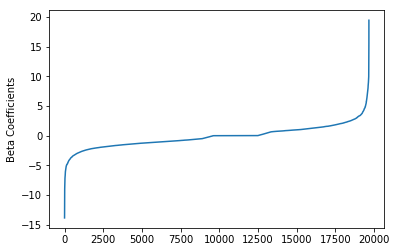

In [22]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model

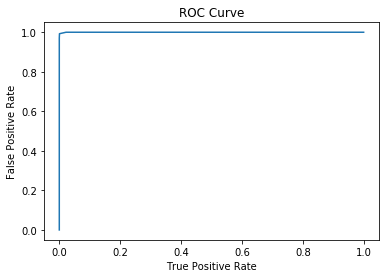

Training set areaUnderROC: 0.9999088557273562


In [23]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and recall

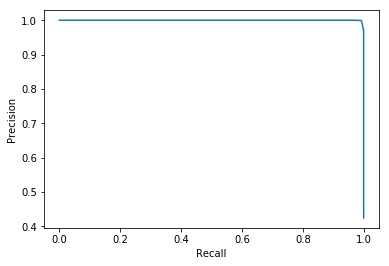

In [24]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Validate the model

In [25]:
lrPreds = lrModel.transform(validate)
lrPreds.select('id','prediction').show(5)

+-----+----------+
|   id|prediction|
+-----+----------+
|10003|       0.0|
|10013|       0.0|
|10016|       0.0|
|10018|       0.0|
|10036|       0.0|
+-----+----------+
only showing top 5 rows



### Evaluate the Logistic Regression model

In [26]:
lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.8043579820397603


In [27]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lrPreds)
print("Accuracy of Logistic Regression is = %g"% (lr_accuracy))

Accuracy of Logistic Regression is = 0.768276


## Decision Tree Classifier


In [28]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(validate)
dtPreds.show(5)
#dtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----------+
|   id|                text|target|            only_str|               words|            filtered|            features|label|  rawPrediction|         probability|prediction|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----------+
|10003|I want some tsuna...|     0|I want some tsuna...|[i, want, some, t...|[want, tsunami, t...|(19663,[80,91,468...|    0| [2085.0,819.0]|[0.71797520661157...|       0.0|
|10013|love 106.1 The Tw...|     0|love . The Twiste...|[love, the, twist...|[love, twister, t...|(19663,[52,296,54...|    0| [2085.0,819.0]|[0.71797520661157...|       0.0|
|10016|Crazy Mom Threw T...|     0|Crazy Mom Threw T...|[crazy, mom, thre...|[crazy, mom, thre...|(19663,[0,1,296,6...|    0|[1115

### Evaluate the Decision Tree model

One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods, such as Random Forest and Gradient-Boosted Tree.

In [29]:
dtEval = BinaryClassificationEvaluator()
dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(dtROC))

Test Area Under ROC: 0.6332041395830809


In [30]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dtPreds)
print("Accuracy of Decision Trees is = %g"% (dt_accuracy))

Accuracy of Decision Trees is = 0.651034


### Make Predictions based on Decision Tree Model

In [31]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target', maxDepth = 3)
dtModel = dt.fit(trainData)
dtPreds = dtModel.transform(testData)
dtPreds.show(5)

+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|                text|            only_str|               words|            filtered|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  0|Just happened a t...|Just happened a t...|[just, happened, ...|[happened, terrib...|(11358,[32,55,469...|[2582.0,1033.0]|[0.71424619640387...|       0.0|
|  2|Heard about #eart...|Heard about #eart...|[heard, about, ea...|[heard, earthquak...|(11358,[181,196,4...|[2582.0,1033.0]|[0.71424619640387...|       0.0|
|  3|there is a forest...|there is a forest...|[there, is, a, fo...|[forest, fire, sp...|(11358,[7,54,338,...|    [36.0,71.0]|[0.33644859813084...|       1.0|
|  9|Apocalypse lighti...|Apocalypse lighti...

In [32]:
dtPreds.select('id','prediction').withColumnRenamed('prediction','target').write.csv('dt_output.csv',header=True)

## Random Forest Classifier

In [33]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(validate)
rfPreds.select('id', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|   id|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|10003|[11.5825087077925...|       0.0|[0.57912543538962...|
|10013|[12.4697301315272...|       0.0|[0.62348650657636...|
|10016|[11.5825087077925...|       0.0|[0.57912543538962...|
|10018|[11.5825087077925...|       0.0|[0.57912543538962...|
|10036|[11.5825087077925...|       0.0|[0.57912543538962...|
|10047|[11.5825087077925...|       0.0|[0.57912543538962...|
|10055|[11.5825087077925...|       0.0|[0.57912543538962...|
|10070|[10.8178425579401...|       0.0|[0.54089212789700...|
|10072|[10.4610883680546...|       0.0|[0.52305441840273...|
|10083|[10.0223704636714...|       0.0|[0.50111852318357...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



### Evaluate the Random Forest Classifier

In [34]:
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.6957448731036682


In [35]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rfPreds)
print("Accuracy of Random Forests is = %g"% (rf_accuracy))

Accuracy of Random Forests is = 0.581379


### Make Predictions using the Model

In [36]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
rfModel = rf.fit(trainData)
rfPreds = rfModel.transform(testData)
#rfPreds.select('id', 'rawPrediction', 'prediction', 'probability').show(10)

In [37]:
#rfPreds.select('id','prediction').withColumnRenamed('prediction','target').write.csv('rf_output',header=True,mode='overwrite')

## Gradient Boosting Classifier

In [38]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPreds = gbtModel.transform(validate)
gbtPreds.show(5)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|   id|                text|target|            only_str|               words|            filtered|            features|label|       rawPrediction|         probability|prediction|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|10003|I want some tsuna...|     0|I want some tsuna...|[i, want, some, t...|[want, tsunami, t...|(19663,[80,91,468...|    0|[0.50310902378198...|[0.73227936310753...|       0.0|
|10013|love 106.1 The Tw...|     0|love . The Twiste...|[love, the, twist...|[love, twister, t...|(19663,[52,296,54...|    0|[0.50310902378198...|[0.73227936310753...|       0.0|
|10016|Crazy Mom Threw T...|     0|Crazy Mom Threw T...|[crazy, mom, thre...|[crazy, mom, thre...|(19663,

### Evaluate the Gradient-Boosted Tree Classifier

In [39]:
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))

Test Area Under ROC: 0.7420460291185792


In [40]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
gb_accuracy = evaluator.evaluate(gbtPreds)
print("Accuracy of GBT is = %g"% (gb_accuracy))

Accuracy of GBT is = 0.681379


In [41]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(trainData)
gbtPreds = gbtModel.transform(testData)
gbtPreds.select('id','prediction').show(5)

+---+----------+
| id|prediction|
+---+----------+
|  0|       0.0|
|  2|       0.0|
|  3|       1.0|
|  9|       0.0|
| 11|       0.0|
+---+----------+
only showing top 5 rows



In [42]:
#gbtPreds.select('id','prediction').withColumnRenamed('prediction','target').write.csv('gbt_output.csv',header=True,,mode='overwrite')